Referenced from: [Kaggle Genetic Algorithm](https://www.kaggle.com/code/tanmayunhale/genetic-algorithm-for-feature-selection)

This link is very useful, so I just copied the code and made some modifications to make it more readable.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

Read the dataset and check the first few rows.

In [2]:
data = pd.read_csv('../dataset/lab3/breast_cancer_wincolsin.csv')

In [3]:
display(data.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

We will use all of the algorithms to see which one performs the best. Then apply the genetic algorithm to "tune" the parameters of the algorithm to improve the accuracy of the algorithm.

The algorithms include:

- Linear Support Vector Machine (LinearSVM)
- Radial Support Vector Machine (RadialSVM)
- Logistic Regression (Logistic)
- Random Forest (RandomForest)
- AdaBoost (AdaBoost)
- Decision Tree (DecisionTree)
- K-Nearest Neighbors (KNeighbors)
- Gradient Boosting (GradientBoosting)

In [5]:
classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

In [6]:
models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]

In [9]:
def acc_score(df, label):
    """
    Returns a dataframe with the accuracy of each classifier

    Parameters:
    df (DataFrame): The dataset
    label (Series): The target variable

    Returns:
    DataFrame: A dataframe with the accuracy of each classifier
    """
    Score = pd.DataFrame({"Classifier" : classifiers})
    acc = []
    X_train, X_test, Y_train, Y_test = train_test_split(df, label, test_size=0.25, random_state=42) # choose random_state = 42 for reproducibility
    for model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test, predictions))
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False, inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

In [9]:
def plot(score, x, y, c = "b"):
    """
    Plots the accuracy of each classifier

    Parameters:
    score (DataFrame): The accuracy of each classifier
    x (int): The lower limit of the y-axis
    y (int): The upper limit of the y-axis
    c (str): The color of the plot

    Returns:
    None
    """
    gen = [1, 2, 3, 4, 5] # want to plot for 5 generations
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [10]:
def initilization_of_population(size, n_feat):
    """
    Returns a list of chromosomes

    Parameters:
    size (int): The number of chromosomes
    n_feat (int): The number of features

    Returns:
    list: A list of chromosomes
    """
    population = []
    for _ in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        # right now the chromosome is an array of True values: [True, True, True, ...]  
        chromosome[:int(0.3*n_feat)]=False # select 30% of the features         
        np.random.shuffle(chromosome) # shuffle the array to mix the False and True values
        population.append(chromosome)
    return population

In [11]:
def selection(pop_after_fit, n_parents):
    """This function selects the best chromosomes from the current population

    Args:
        pop_after_fit (list): The population after fitness is calculated
        n_parents (int): The number of parents to be selected

    Returns:
        list: The selected parents
    """
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i]) # select the top n_parents chromosomes
    return population_nextgen

In [19]:
def crossover(pop_after_sel):
    """This function performs the crossover operation

    Args:
        pop_after_sel (list): The selected parents

    Returns:
        list: The population after crossover
    """    
    pop_nextgen: list = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

In [20]:
def mutation(pop_after_cross,mutation_rate,n_feat):
    """This function performs the mutation operation

    Args:
        pop_after_cross (list): The population after crossover
        mutation_rate (float): The rate of mutation
        n_feat (int): The number of features

    Returns:
        list: The population after mutation
    """    
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0, len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for _ in range(0, mutation_range):
            pos = randint(0, n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

In [34]:
def generations(X_train, X_test, Y_train, Y_test, model, size, n_feat, n_parents, mutation_rate, n_gen):
    """
    Returns the best chromosome and the best score

    Args:
        X_train (DataFrame): The training dataset
        X_test (DataFrame): The testing dataset
        Y_train (Series): The target variable of the training dataset
        Y_test (Series): The target variable of the testing dataset
        model (object): The model to be used
        size (int): The number of chromosomes
        n_feat (int): The number of features
        n_parents (int): The number of parents to be selected
        mutation_rate (float): The rate of mutation
        n_gen (int): The number of generations

    Returns:
        list: The best chromosome
        list: The best score
    """
    
    best_chromo= []
    best_score= []
    population_nextgen = initilization_of_population(size,n_feat) # create the initial population
    for i in range(n_gen):
        scores = []
        for chromosome in population_nextgen:
            model.fit(X_train.iloc[:,chromosome],Y_train) # train the model using the selected features  
            predictions = model.predict(X_test.iloc[:,chromosome]) # test the model on the testing data
            scores.append(accuracy_score(Y_test,predictions)) # calculate the accuracy of the model
        scores, population = np.array(scores), np.array(population_nextgen) 
        inds = np.argsort(scores)                                    
        final_scores = list(scores[inds][::-1])
        final_polulation_list = list(population[inds,:][::-1]) 
        print('Best score in generation',i+1,':',final_scores[:1]) # print the best score in the current generation
        pop_after_sel = selection(final_polulation_list,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(final_polulation_list[0])
        best_score.append(final_scores[0])
    return best_chromo, best_score

In [12]:
label_bc = data["diagnosis"]
label_bc = np.where(label_bc == 'M',1,0)
data.drop(["id","diagnosis","Unnamed: 32"],axis = 1,inplace = True)

print("Breast Cancer dataset:\n",data.shape[0],"Records\n",data.shape[1],"Features")

Breast Cancer dataset:
 569 Records
 30 Features


In [15]:
score1 = acc_score(data, label_bc)
score1

,Classifier,Accuracy
0,RandomForest,0.972028
1,Logistic,0.965035
2,KNeighbors,0.965035
3,LinearSVM,0.958042
4,GradientBoosting,0.958042
5,AdaBoost,0.958042
6,RadialSVM,0.951049
7,DecisionTree,0.930070


In [35]:
logmodel = RandomForestClassifier(n_estimators = 200, random_state = 0)
X_train,X_test, Y_train, Y_test = train_test_split(data, label_bc)
chromo_df_bc, score_bc = generations(X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test, 
                                     model=logmodel,size = 80,n_feat = data.shape[1],n_parents = 64, 
                                     mutation_rate = 0.20, n_gen=5
                                    )

Best score in generation 1 : [np.float64(0.9790209790209791)]
Best score in generation 2 : [np.float64(0.9790209790209791)]
Best score in generation 3 : [np.float64(0.9790209790209791)]
Best score in generation 4 : [np.float64(0.986013986013986)]
Best score in generation 5 : [np.float64(0.986013986013986)]


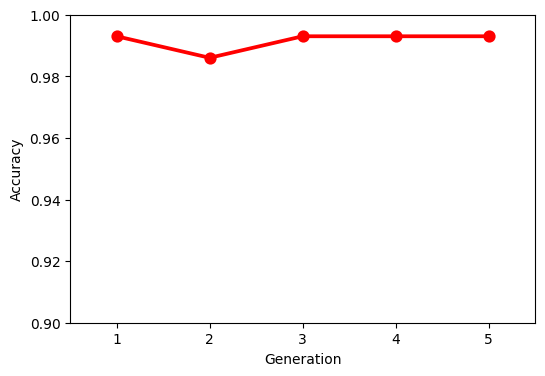

In [25]:
plot(score_bc,0.9,1.0, c = "red")

Homework: Work on `parkinson_disease.csv` and `PCOS.csv` datasets.